# Trading with Deep Reinforcement Learning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch
from agent import Agent
from trading_env import RlTradingEnv
from ppo import PPOTrainer

### Training

In [66]:
class TrainingArgs:
    def __init__(self):
        self.n_actions = 3
        self.learning_rate = 0.0003
        self.total_timesteps = 30000
        self.torch_deterministic = True
        self.cuda = True
        self.wandb_entity = None
        self.parallel_rollouts = False
        self.num_envs = 1
        self.num_steps = 1000
        self.anneal_lr = False
        self.gae = True
        self.gamma = 0.999
        self.gae_lambda = 0.99
        self.num_minibatches = 4
        self.update_epochs = 4
        self.norm_adv = False
        self.clip_coef = 0.2
        self.clip_vloss = True
        self.ent_coef = 0.01
        self.vf_coef = 0.5
        self.max_grad_norm = 0.5
        self.target_kl = None
        self.device='cpu'

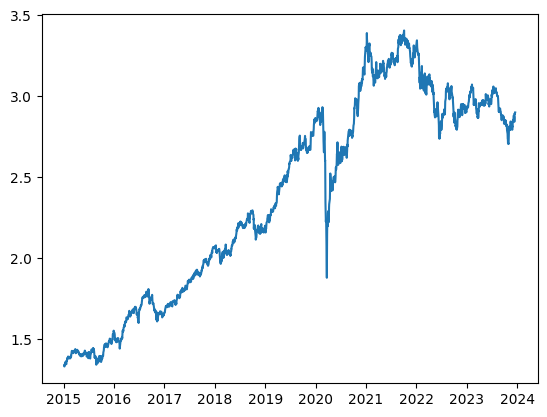

In [67]:
# List of stock tickers
ticker = 'FNZ.NZ'
start_date = pd.Timestamp('2015-01-01')
position_percent = 0.5
num_samples = 2000
refresh_synthetic_data = True

args = TrainingArgs()
rl_env = RlTradingEnv(ticker, 
                      start_date, 
                      position_percent=position_percent, 
                      num_samples=num_samples, 
                      refresh_synthetic_data=refresh_synthetic_data)
grid_dims = rl_env.get_state().shape

ppo = PPOTrainer(args=args, grid_dims=grid_dims)
rl_agent = Agent(3, 1, grid_width=grid_dims[1], grid_height=grid_dims[2])

plt.plot(rl_env.data['Close'])
plt.show()

In [68]:
# Train the agent
total_rewards = ppo.train_ppo(rl_env, rl_agent)

Batch size: 1000
Minibatch size: 250
i: 1	 steps: 1000	 ar: 949.95	 mx: 960.10595703125	 lr: 0.0003	 vl: 29093.0098	 pl: -84.0796	 ent: 1.0864	
i: 2	 steps: 2000	 ar: 20.98	 mx: 960.10595703125	 lr: 0.0003	 vl: 14021.8516	 pl: 75.3087	 ent: 1.0779	
i: 3	 steps: 3000	 ar: 469.36	 mx: 2521.426025390625	 lr: 0.0003	 vl: 51286.5664	 pl: -90.7359	 ent: 1.0566	
i: 4	 steps: 4000	 ar: 1079.14	 mx: 2908.47998046875	 lr: 0.0003	 vl: 55426.9453	 pl: -262.3597	 ent: 1.0259	
i: 5	 steps: 5000	 ar: 1090.44	 mx: 2908.47998046875	 lr: 0.0003	 vl: 42025.0781	 pl: -111.3367	 ent: 1.0173	
i: 6	 steps: 6000	 ar: 681.11	 mx: 2908.47998046875	 lr: 0.0003	 vl: 34634.9531	 pl: 104.7578	 ent: 1.008	
i: 7	 steps: 7000	 ar: 849.03	 mx: 2908.47998046875	 lr: 0.0003	 vl: 22705.3242	 pl: -5.937	 ent: 1.0076	
i: 8	 steps: 8000	 ar: 1138.40	 mx: 3195.23681640625	 lr: 0.0003	 vl: 49105.2969	 pl: -222.4805	 ent: 0.9564	
i: 9	 steps: 9000	 ar: 616.71	 mx: 3195.23681640625	 lr: 0.0003	 vl: 48362.2461	 pl: -37.062	 ent: 

### Inference

In [69]:
actions_dict = defaultdict(int)
data_len = 1960
n_trials = 20
balances = np.zeros((n_trials, data_len + 40))
for i in range(n_trials):
    print(f'Iteration {i+1}')
    rl_env.reset()
    for _ in range(data_len):
        s = torch.tensor(rl_env.get_state(use_synthetic_data=False), dtype=torch.float32).to('cpu')
        action = rl_agent.get_action(s)
        actions_dict[action] += 1
        _, reward, done = rl_env.step(action, use_synthetic_data=False)
    balances[i, :] = rl_env.balance_history

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20


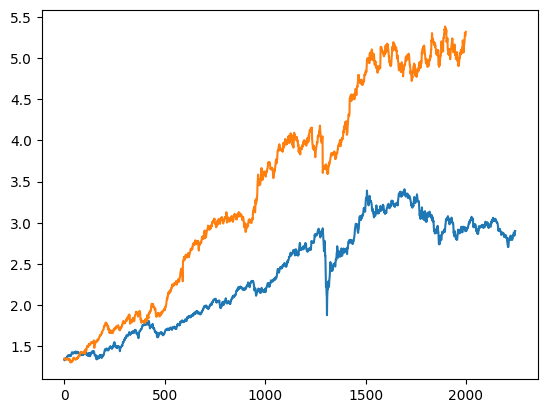

In [70]:
plt.plot(rl_env.data['Close'].values)
plt.plot(rl_env.synthetic_data[:, 0])
plt.show()

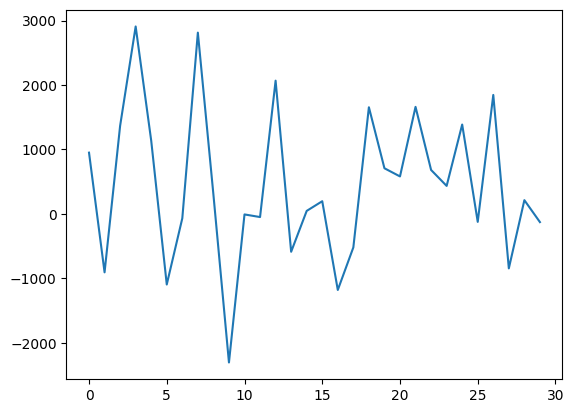

In [71]:
plt.plot(total_rewards)
plt.show()

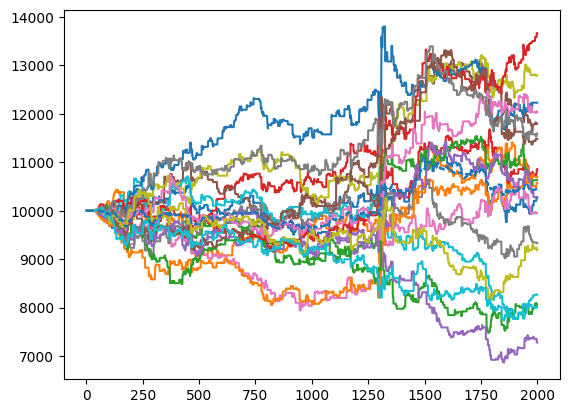

In [72]:
balances_avg = np.mean(balances, axis=0)
plt.plot(balances.T)
plt.plot(balances_avg, linestyle='--')
plt.show()

In [73]:
rl_env.get_trade_history()

,t,position,type,price,units,profit,balance
0,40,short,entry,1.424329,3510.424804,0.000000,10000.000000
1,42,short,exit,1.417887,3510.424804,22.613984,10022.613984
2,42,long,entry,1.417887,3534.348413,0.000000,10022.613984
3,67,long,exit,1.427846,3534.348413,35.199357,10057.813340
4,67,short,entry,1.427846,3522.022382,0.000000,10057.813340
...,...,...,...,...,...,...,...
868,1980,short,entry,2.927952,1407.456645,0.000000,8241.930469
869,1983,short,exit,2.917760,1407.456645,14.344346,8256.274815
870,1983,long,entry,2.917760,1414.830973,0.000000,8256.274815
871,1993,long,exit,2.928388,1414.830973,15.036128,8271.310943


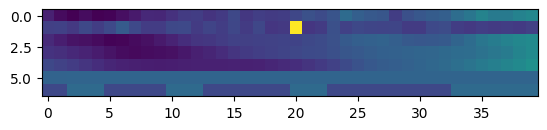

In [74]:
plt.imshow(rl_env.get_state().squeeze().T)
plt.show()

In [76]:
import nest_asyncio
import twint

In [78]:
nest_asyncio.apply()

def get_tweets(search, since, until, output=None, pandas_df=False, limit=None, username=None, verified=True, 
               hide_output=True, lang='en'):
    """
    Wrapper function to get tweets using the twint library
    """
    
    c = twint.Config()
    c.Search = search
    
    c.Since = since
    c.Until = until
    
    if limit is not None:
        c.Limit = limit
    
    if username is not None:
        c.Username = username
        
    c.Verified = verified
    c.Hide_output = hide_output
    c.Lang = lang
    c.Lower_case = True
    c.Count = True
    
    if output is not None:
        c.Store_csv = True
        c.Custom_csv = ['id', 'user_id', 'username', 'tweet']
        c.Output = output

    c.Pandas = pandas_df   
    
    # run search
    twint.run.Search(c)
    
    df = twint.storage.panda.Tweets_df
    
    if pandas_df:
        return twint.storage.panda.Tweets_df
    
    
def hourly_tweet_counts(df):
    """
    Count the number of times that a term has been tweeted about within an hour
    """
    
    # We only need the datetime and tweet fields
    df_tmp = df[['date', 'tweet']].copy()
    # Datetime in string format rounded to hour
    df_tmp['datetime_rnd'] = df_tmp['date'].copy().str[:13] + ':00:00'
    # Convert to datetime format to subtract 1 hour
    df_tmp['datetime_dt'] =  pd.to_datetime(df_tmp['datetime_rnd'], format='%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # Convert back to string format
    df_tmp['datetime'] = df_tmp['datetime_dt'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df_tmp['tweet_count'] = 1
    
    # Aggregate number of tweets by hour
    tweets_agg = df_tmp.groupby('datetime').agg({'tweet_count':'sum'}).reset_index()
   
    return tweets_agg

In [1]:
coin = 'FNZ' 
since = '2021-01-01'
until = '2021-12-31'

tweets_df = get_tweets(coin, since, until, pandas_df=True, hide_output=True)

NameError: name 'get_tweets' is not defined